In [2]:
import numpy as np
import os
import glob 
import time 
import pandas as pd
import shutil
import re
import mdtraj as md
import MDAnalysis as mda
import pickle
import pickle as p 
import csv
import sys
import subprocess
import xml.etree.ElementTree as ET
import requests
import concurrent.futures
import multiprocessing
import nglview as nv
import h5py
# import matplotlib as mpl
# import matplotlib.patheffects as path_effects
# import matplotlib.patches as patches
import html
import biobox as bb
import tempfile

import matplotlib
# matplotlib.use('Agg')  # 使用不需要GUI的后端
import matplotlib.pyplot as plt

import molearn
import torch
import glob as glob
import MDAnalysis.analysis.rms as rms
import seaborn as sns
import pickle
import networkx as nx
sys.path.insert(0, os.path.join(os.path.abspath(os.pardir),'src'))

from Bio import PDB
from tqdm import tqdm
from time import time as t
from urllib.request import urlretrieve as download
from Bio.Blast import NCBIWWW, NCBIXML
from Bio.Blast.Applications import NcbipsiblastCommandline
from collections import defaultdict
from Bio.PDB import PPBuilder
from Bio.SeqUtils import seq1
from modeller import *
from modeller.automodel import *
from Bio.PDB import PDBParser
from MDAnalysis.analysis import align
from mpi4py import MPI
from glob import glob
from pprint import pprint as pp

from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from glob import glob as g
from tqdm.notebook import tqdm
from collections import Counter
from matplotlib.ticker import FuncFormatter
from collections import defaultdict
from pymol import cmd
from scipy.interpolate import interp1d
from mpl_toolkits import mplot3d
from scipy import stats
from sklearn.cluster import AgglomerativeClustering, SpectralClustering
from matplotlib.colors import BoundaryNorm
from numpy.linalg import norm
from molearn.data import PDBData
from molearn.trainers import Trainer
from molearn.models.small_foldingnet import Small_AutoEncoder
from molearn.analysis.analyser import MolearnAnalysis
from copy import deepcopy
from molearn.analysis import MolearnGUI
from scipy.ndimage import rotate
from numpy.linalg import inv
from sklearn.cluster import HDBSCAN
from sklearn.metrics import silhouette_score
from itertools import combinations
from urllib.request import urlretrieve
from urllib.error import URLError
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
from sklearn.tree import export_graphviz
from sklearn import tree
from scipy.stats import pearsonr


Learning the conformational ensemble with an Autoencoder.

In [6]:
"""
Final training script for Small_AutoEncoder
"""

import os
import numpy as np
import torch
from copy import copy

# Adjust these imports to match your package layout if needed
from molearn.data.pdb_data import PDBData
from molearn.trainers.trainer import Trainer


def ensure_dir(path: str) -> None:
    os.makedirs(path, exist_ok=True)


def to_tensor_subset(ds, idx):
    """Return a torch.Tensor subset of ds at rows idx (float32, contiguous).

    Supports ds being a torch.Tensor, numpy.ndarray, or a generic sequence of
    array-likes/tensors. idx is a list/array of row indices.
    """
    idx = np.asarray(idx, dtype=np.int64)

    if isinstance(ds, torch.Tensor):
        idx_t = torch.as_tensor(idx, dtype=torch.long, device=ds.device)
        sub = ds.index_select(0, idx_t).contiguous()
        return sub.to(dtype=torch.float32)

    elif isinstance(ds, np.ndarray):
        sub = np.ascontiguousarray(ds[idx])
        return torch.from_numpy(sub).to(dtype=torch.float32)

    else:
        # Generic fallback: try to materialize as numpy then to torch
        seq = [ds[i] for i in idx]
        try:
            arr = np.asarray(seq)
            return torch.from_numpy(np.ascontiguousarray(arr)).to(dtype=torch.float32)
        except Exception:
            # Elements might already be tensors
            if all(isinstance(x, torch.Tensor) for x in seq):
                return (
                    torch.stack([x.detach().cpu() for x in seq], dim=0)
                    .to(dtype=torch.float32)
                    .contiguous()
                )
            raise TypeError(f"Unsupported dataset type for subset: {type(ds)}")


def clone_with_subset(src, idx):
    """Shallow-clone a PDBData-like object and replace .dataset with a tensor subset.
    Resets transient fields that may cache state/dataloaders.
    """
    new = copy(src)
    new.dataset = to_tensor_subset(src.dataset, idx)
    # Reset common transient fields if they exist on this class
    for attr in (
        "train_dataset",
        "valid_dataset",
        "_dataloader",
        "_loader",
        "_sampler",
        "indices",
        "_indices",
        "_prepared",
        "std",
        "mean",
    ):
        if hasattr(new, attr):
            try:
                setattr(new, attr, None)
            except Exception:
                pass
    return new


def train_autoencoder_on_folder(
    folder_name: str,
    checkpoint_suffix: str,
    manual_seed: int = 42,
    valid_ratio: float = 0.12,
    batch_size: int = 8,
) -> None:
    print(f"\nStarting training on: {folder_name}")

    # Reproducibility
    rng = np.random.RandomState(seed=manual_seed)
    torch.manual_seed(manual_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(manual_seed)

    data = PDBData()

    # Collect PDB files, excluding any pre-existing combined.pdb
    files = sorted(
        [
            f
            for f in os.listdir(folder_name)
            if os.path.isfile(os.path.join(folder_name, f)) and f != "combined.pdb"
        ]
    )
    assert len(files) > 0, "No PDB files found in folder."

    # Merge into combined.pdb using MODEL/ENDMDL records
    combined_file_path = os.path.join(folder_name, "combined.pdb")
    with open(combined_file_path, "w") as combined_file:
        for i, filename in enumerate(files):
            file_path = os.path.join(folder_name, filename)
            with open(file_path, "r") as infile:
                # Strip any existing MODEL/END markers from components
                lines = [line for line in infile if not line.startswith(("MODEL", "END"))]
            combined_file.write(f"MODEL {i}\n")
            combined_file.writelines(lines)
            combined_file.write("ENDMDL\n")
        combined_file.write("END\n")

    # Load and prepare data
    data.import_pdb(filename=combined_file_path)
    data.fix_terminal()
    data.atomselect(atoms=["CA", "C", "N", "CB", "O"])  # backbone + CB + O
    data.prepare_dataset()
    # print(data._mol)  # uncomment for a quick sanity check

    # Split train/test indices deterministically
    num_models = int(data.dataset.shape[0])
    assert num_models >= 2, f"Need at least 2 models; got {num_models}"

    indices = rng.permutation(num_models)
    num_test = max(1, int(num_models * valid_ratio))
    test_indices = indices[:num_test]
    train_indices = indices[num_test:]

    # Persist indices for reproducibility
    np.savetxt(f"train_model_indices_{checkpoint_suffix}.txt", train_indices, fmt="%d")
    np.savetxt(f"test_model_indices_{checkpoint_suffix}.txt", test_indices, fmt="%d")

    # Create subset data objects without using deepcopy
    data_train_obj = clone_with_subset(data, train_indices)
    data_test_obj = clone_with_subset(data, test_indices)

    print(
        f"NUM OF TRAIN SET: {len(data_train_obj.dataset)} | "
        f"dtype: {data_train_obj.dataset.dtype} | "
        f"shape: {tuple(data_train_obj.dataset.shape)}"
    )
    print("FINISH preparing data")

    # Trainer setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    trainer = Trainer(device=device)
    trainer.set_data(
        data_train_obj,
        batch_size=batch_size,
        validation_split=0.1,
        manual_seed=manual_seed,
    )
    trainer.set_autoencoder(Small_AutoEncoder, out_points=data.dataset.shape[-1])
    trainer.prepare_optimiser()

    # Output folders
    base_result_dir = f"Results/run_trial_BRAFActivationLoop_postalign_{checkpoint_suffix}"
    log_folder = os.path.join(base_result_dir, "xbb_foldingnet_checkpoints")
    checkpoint_folder = base_result_dir
    ensure_dir(log_folder)

    # Training loop: continue until there is no new best
    best = float("inf")
    while True:
        trainer.run(
            max_epochs=32 + trainer.epoch,
            log_filename="log_file.dat",
            log_folder=log_folder,
            checkpoint_folder=checkpoint_folder,
        )
        if not (best > trainer.best):
            break
        best = trainer.best

    print(f"Training completed for {folder_name}")
    print(f"  Best loss: {trainer.best:.6f}")
    print(f"  Best checkpoint: {getattr(trainer, 'best_name', 'N/A')}")

if __name__ == '__main__':
    # Path: RMSD ≤ 11
    folder = 'Results/fitted_matlab_segments/mustang_endsAlignment_cleaned_noOutliers'
    suffix = 'cleaned_noOutlier_11_checkpoint_newsplit'

    #Train
    train_autoencoder_on_folder(folder, suffix)



Starting training on: Results/fitted_matlab_segments/mustang_endsAlignment_cleaned_noOutliers
Dataset shape: torch.Size([2428, 3, 27])
mean: 111.43872312785946
 std: 20.417273447197523
NUM OF TRAIN SET: 2137 | dtype: torch.float32 | shape: (2137, 3, 27)
FINISH preparing data
device: cpu
epoch              : 0
train_mse_loss     : 0.109651
train_loss         : 0.109651
valid_mse_loss     : 0.023567
valid_loss         : 0.023567
train_seconds      : 20.867896
valid_seconds      : 0.578951
checkpoint_seconds : 0.062473
total_seconds      : 21.509320

epoch              : 1
train_mse_loss     : 0.017711
train_loss         : 0.017711
valid_mse_loss     : 0.027604
valid_loss         : 0.027604
train_seconds      : 20.761786
valid_seconds      : 0.522373
checkpoint_seconds : 0.044200
total_seconds      : 21.328359

epoch              : 2
train_mse_loss     : 0.012813
train_loss         : 0.012813
valid_mse_loss     : 0.012076
valid_loss         : 0.012076
train_seconds      : 23.111238
valid

KeyboardInterrupt: 

In [3]:
import glob
file_pattern = 'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/checkpoint_*.ckpt'

print(glob.glob(file_pattern))

matching_files = sorted(glob.glob(file_pattern))

if len(matching_files) == 0:
    raise FileNotFoundError(f"No files matched the pattern: {file_pattern}")

networkfile = matching_files[0]

checkpoint = torch.load(networkfile, map_location=torch.device('cpu'))
net = Small_AutoEncoder(**checkpoint['network_kwargs'])
net.load_state_dict(checkpoint['model_state_dict'])

print("Matched files:", matching_files)
print("Using file:", networkfile)
print("Network kwargs:", checkpoint['network_kwargs'])

['Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit\\checkpoint_1_epoch277_loss0.0014215417926641348.ckpt', 'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit\\checkpoint_epoch87_loss0.0019971790206575885.ckpt']
Matched files: ['Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit\\checkpoint_1_epoch277_loss0.0014215417926641348.ckpt', 'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit\\checkpoint_epoch87_loss0.0019971790206575885.ckpt']
Using file: Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit\checkpoint_1_epoch277_loss0.0014215417926641348.ckpt
Network kwargs: {'out_points': 27}


In [4]:
import os
data = PDBData()
folder_name = 'Results/fitted_matlab_segments/mustang_endsAlignment_cleaned_noOutliers'
combined_file_path = os.path.join(folder_name, 'combined.pdb')
data.import_pdb(filename=combined_file_path)
data.fix_terminal()
data.atomselect(atoms = ['CA', 'C', 'N', 'CB', 'O'])
data.prepare_dataset()

Dataset shape: torch.Size([2428, 3, 27])
mean: 111.43872312785946
 std: 20.417273447197523


In [5]:
import numpy as np, torch
from copy import copy
MA = MolearnAnalysis()
MA.set_network(net)

def to_tensor_subset(ds, idx):
    """Return torch.Tensor subset (float32, contiguous)."""
    idx = np.asarray(idx, dtype=np.int64)
    if isinstance(ds, torch.Tensor):
        idx_t = torch.as_tensor(idx, dtype=torch.long, device=ds.device)
        sub = ds.index_select(0, idx_t).contiguous()
        return sub.to(dtype=torch.float32)
    elif isinstance(ds, np.ndarray):
        sub = np.ascontiguousarray(ds[idx])
        return torch.from_numpy(sub).to(dtype=torch.float32)
    else:
        # generic fallback: try list->numpy->tensor; or stack tensors
        seq = [ds[i] for i in idx]
        try:
            return torch.from_numpy(np.ascontiguousarray(np.asarray(seq))).to(torch.float32)
        except Exception:
            return torch.stack([
                (x.detach().cpu() if isinstance(x, torch.Tensor) else torch.as_tensor(x))
                for x in seq
            ], dim=0).to(torch.float32).contiguous()

def clone_with_subset(src, idx):
    """Shallow clone obj and replace .dataset & .indices; clear transient caches."""
    new = copy(src)
    new.dataset = to_tensor_subset(src.dataset, idx)
    new.indices = np.asarray(idx, dtype=np.int64)
    for attr in ("train_dataset","valid_dataset","_dataloader","_loader","_sampler","_prepared"):
        if hasattr(new, attr):
            try: setattr(new, attr, None)
            except Exception: pass
    return new


checkpoint_suffix = 'cleaned_noOutlier_11_checkpoint_newsplit'
train_file = f"train_model_indices_{checkpoint_suffix}.txt"
test_file = f"test_model_indices_{checkpoint_suffix}.txt"

train_indices = np.loadtxt(train_file, dtype=int)
test_indices = np.loadtxt(test_file, dtype=int)

print("Train indices loaded:", train_indices.shape)
print("Test indices loaded:", test_indices.shape)
print(test_indices)

data_train = clone_with_subset(data, train_indices)
data_test = clone_with_subset(data, test_indices)
data_train.dataset = data.dataset[train_indices]
data_test.dataset = data.dataset[test_indices]
data_train.indices = train_indices
data_test.indices = test_indices

MA.set_dataset("train", data_train)
MA.set_dataset("test", data_test)


Train indices loaded: (2137,)
Test indices loaded: (291,)
[ 952 1189  582  480 1607 1951  610 1550  670  111 1029 2010 1070 1194
  239 2195   56 2331  707 1675 1622 2242 1797 1765 1514 1558 1882 1567
  479  654  630 2082 1341  134 1943  678 1702 1446  188   93 1041  927
  759  555 1490 1569 1867 2318  443  196 1068  978 1900  765 1535  973
  857 1886 1269 1355 1583 2103 1125  246 2392 1754  282 1602 1547 2138
  211 1054  618  598 1967 1310  974  173 2134 1133 2113 1601 1242  414
 1036 1225 1387  208 2141 1268 1750  790 2076   44 1477 1100  836 1185
 1719  350  642  463 2338 2276  259 1131 2212 2048 1898 2204 2175 1061
  637 1422 1333 1764 2417  911 1871  913 1562 1084  649 2080 1743 1398
 1383  296 1837  808 1418 1004 1386 1798 1244 2399  387  733 1299  472
 1887  100 1178  486 1283 1465  471  210 1932  279  916 2129 1113 1666
  464 2136  422 1073 2394  251 2193 2197 2337 1557 1271  785  679  170
  218 1732 1480 1247  744 1320 1423  179 1703  229 1877 1027  807  361
 1541  812  596  90

In [9]:
from copy import deepcopy
MA = MolearnAnalysis()
MA.set_network(net)

checkpoint_suffix = 'cleaned_noOutlier_11_checkpoint_newsplit'
train_file = f"train_model_indices_{checkpoint_suffix}.txt"
test_file = f"test_model_indices_{checkpoint_suffix}.txt"

train_indices = np.loadtxt(train_file, dtype=int)
test_indices = np.loadtxt(test_file, dtype=int)

print("Train indices loaded:", train_indices.shape)
print("Test indices loaded:", test_indices.shape)
print(test_indices)

data_train = deepcopy(data)
data_test = deepcopy(data)
data_train.dataset = data.dataset[train_indices]
data_test.dataset = data.dataset[test_indices]
data_train.indices = train_indices
data_test.indices = test_indices

MA.set_dataset("training", data_train)
MA.set_dataset("test", data_test)


Train indices loaded: (2137,)
Test indices loaded: (291,)
[ 952 1189  582  480 1607 1951  610 1550  670  111 1029 2010 1070 1194
  239 2195   56 2331  707 1675 1622 2242 1797 1765 1514 1558 1882 1567
  479  654  630 2082 1341  134 1943  678 1702 1446  188   93 1041  927
  759  555 1490 1569 1867 2318  443  196 1068  978 1900  765 1535  973
  857 1886 1269 1355 1583 2103 1125  246 2392 1754  282 1602 1547 2138
  211 1054  618  598 1967 1310  974  173 2134 1133 2113 1601 1242  414
 1036 1225 1387  208 2141 1268 1750  790 2076   44 1477 1100  836 1185
 1719  350  642  463 2338 2276  259 1131 2212 2048 1898 2204 2175 1061
  637 1422 1333 1764 2417  911 1871  913 1562 1084  649 2080 1743 1398
 1383  296 1837  808 1418 1004 1386 1798 1244 2399  387  733 1299  472
 1887  100 1178  486 1283 1465  471  210 1932  279  916 2129 1113 1666
  464 2136  422 1073 2394  251 2193 2197 2337 1557 1271  785  679  170
  218 1732 1480 1247  744 1320 1423  179 1703  229 1877 1027  807  361
 1541  812  596  90

TypeError: __deepcopy__() takes exactly 0 positional arguments (1 given)

In [5]:
# Keep only ATOM(/HETATM)/TER lines; append END
import os, numpy as np

def strip_to_atoms(in_path: str, out_path: str, keep_hetatm: bool = True, add_end: bool = True):
    keep = {"ATOM", "TER"} if not keep_hetatm else {"ATOM", "HETATM", "TER"}
    wrote_any = False
    last = ""
    with open(in_path, "r") as fin, open(out_path, "w") as fout:
        for line in fin:
            rec = line[:6].strip()
            if rec in keep:
                fout.write(line)
                wrote_any = True
                last = rec
    if add_end and wrote_any and last != "END":
        with open(out_path, "a") as fout:
            fout.write("END\n")

In [6]:
# Save structures for training dataset (MDAnalysis-based)
import os
import numpy as np

def ifnotmake(dir_path: str):
    os.makedirs(dir_path, exist_ok=True)
    return dir_path

print(sorted(np.append(train_indices, test_indices)))

out_dir = ifnotmake(
    'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_train'
)

u = data._mol  # MDAnalysis.Universe provided by PDBData
# Match your earlier atom selection: CA, C, N, CB, O
ag = u.select_atoms("name CA C N CB O")

for i, index in enumerate(np.asarray(train_indices, dtype=int)):
    if index < 0 or index >= len(u.trajectory):
        raise IndexError(f"Index {index} out of range 0..{len(u.trajectory)-1}")
    u.trajectory[index]  # jump to the given frame
    tmp = os.path.join(out_dir, f"s{i}.tmp.pdb")
    final = os.path.join(out_dir, f"s{i}.pdb")
    ag.write(tmp)  # write PDB for this frame
    strip_to_atoms(tmp, final, keep_hetatm=False, add_end=True)  # strip headers
    os.remove(tmp)

print("Done writing training PDBs ->", out_dir)

    

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [12]:
"""
Save structures for training dataset
"""
def ifnotmake(dir_path):
    if not os.path.isdir(dir_path):
        os.makedirs(dir_path)
    return dir_path

print(sorted(np.append(train_indices, test_indices)))

ifnotmake('Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_train/')
for i, index in enumerate(train_indices):
    print(index)
    data._mol.set_current(index)  # Switch to the frame at the given index
    pdb_lines = data._mol.get_pdb_data() 
    with open(f'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_train/s{i}.pdb', 'w') as f:
        for line in pdb_lines:
            if isinstance(line, list) and line[0] == 'ATOM':
                atom_serial = line[1]
                atom_name = line[2]
                res_name = line[3]
                chain_id = line[4]
                res_seq = line[5]
                x, y, z = line[6:9]
                occupancy = line[10]
                b_factor = line[9]
                element = line[11]

                pdb_line = f"{'ATOM':<6}{atom_serial:>5} {atom_name:^4}{res_name:>4} {chain_id}{res_seq:>4}    {x:8.3f}{y:8.3f}{z:8.3f}{occupancy:6.2f}{b_factor:6.2f}          {element:>2}"
                f.write(pdb_line + '\n')
    

    

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

AttributeError: 'Universe' object has no attribute 'set_current'

In [7]:
# Save structures for test dataset (MDAnalysis-based)
# All code/comments in English
import os
import numpy as np

def ifnotmake(dir_path: str):
    os.makedirs(dir_path, exist_ok=True)
    return dir_path

out_dir = ifnotmake(
    'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_test'
)

u = data._mol  # MDAnalysis.Universe provided by PDBData
# Match your earlier atom selection: CA, C, N, CB, O
ag = u.select_atoms("name CA C N CB O")

for i, index in enumerate(np.asarray(test_indices, dtype=int)):
    if index < 0 or index >= len(u.trajectory):
        raise IndexError(f"Index {index} out of range 0..{len(u.trajectory)-1}")
    u.trajectory[index]  # jump to the given frame
    tmp = os.path.join(out_dir, f"s{i}.tmp.pdb")
    final = os.path.join(out_dir, f"s{i}.pdb")
    ag.write(tmp)  # write PDB for this frame
    strip_to_atoms(tmp, final, keep_hetatm=False, add_end=True)  # strip headers
    os.remove(tmp)

print("Done writing test PDBs ->", out_dir)


Done writing test PDBs -> Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_test


In [ ]:
"""
Save structures for test dataset
"""
ifnotmake('Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_test/')
for i, index in enumerate(test_indices):
    print(index)
    data._mol.set_current(index) 
    pdb_lines = data._mol.get_pdb_data() 
    with open(f'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_test/s{i}.pdb', 'w') as f:
        for line in pdb_lines:
            if isinstance(line, list) and line[0] == 'ATOM':
                atom_serial = line[1]
                atom_name = line[2]
                res_name = line[3]
                chain_id = line[4]
                res_seq = line[5]
                x, y, z = line[6:9]
                occupancy = line[10]
                b_factor = line[9]
                element = line[11]

                pdb_line = f"{'ATOM':<6}{atom_serial:>5} {atom_name:^4}{res_name:>4} {chain_id}{res_seq:>4}    {x:8.3f}{y:8.3f}{z:8.3f}{occupancy:6.2f}{b_factor:6.2f}          {element:>2}"
                f.write(pdb_line + '\n')

1198
1599
864
629
111
1812
1594
2162
819
414
1984
1001
1282
1658
1368
808
2306
1455
977
2308
338
1901
653
2168
1995
1355
1840
454
2046
349
1284
1
1708
130
1664
1508
574
1777
166
882
2101
952
1335
1727
2268
333
2218
1954
1374
1770
1226
1035
881
2185
1460
1451
176
1648
1732
357
632
214
354
211
1073
1308
1576
1676
455
1380
660
1782
1754
1695
1975
2221
2082
2250
8
839
2136
252
1488
847
885
642
1537
1917
228
1880
373
427
74
1045
385
1138
450
677
596
2333
58
2245
1825
1555
59
1837
1304
387
343
672
188
863
993
1450
1569
2154
1422
2336
806
1971
514
780
2252
172
1475
55
777
339
1886
630
1987
1382
208
1031
2264
374
256
2201
336
1274
2236
1137
1753
2019
526
1925
363
1542
51
1527
2238
515
646
1810
289
2427
2078
559
1413
1235
1694
302
1519
281
902
2102
1254
119
1415
1013
1148
674
1666
1159
1014
1699
1406
1495
102
1110
161
103
901
1329
2009
1270
2182
1914
1814
1499
1820
2346
182
1960
648
510
1150
1641
2334
723
924
844
554
743
1846
1386
1990
1953
2036
1309
2131
362
605
2095
1596
2400
1262
1071
203
23

In [8]:
directory_name = 'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/decoded_train'

# Create the output directory if it doesn't exist
ifnotmake(directory_name)

# Get latent coordinates from the trained model (2D latent space for training set)
latent_coords = MA.get_encoded('train') 

print(latent_coords)

# Generate reconstructed 3D coordinates from the latent coordinates
crd_ref = MA.generate(latent_coords.numpy().reshape(1, len(latent_coords), 2))

# Load the original multi-model structure (combined.pdb) as a trajectory
u = mda.Universe(combined_file_path)

# For each structure in the training set
for i, idx in enumerate(train_indices):
    coords = crd_ref[i]             # Get reconstructed coordinates
    u.trajectory[idx]               # Switch to the correct frame in the trajectory

    mol = u.select_atoms("name CA")  # Select C-alpha atoms only
    mol.positions = coords           # Replace coordinates with reconstructed ones

    mol.write(os.path.join(directory_name, f"s{i}.pdb")) 

encoding train: 100%|██████████| 2137/2137 [00:05<00:00, 415.10it/s]


tensor([[[ 54.5956],
         [117.4222]],

        [[ 82.6608],
         [ 70.4172]],

        [[ 69.6073],
         [-12.6352]],

        ...,

        [[100.4319],
         [-89.1567]],

        [[ 66.1057],
         [ -3.0361]],

        [[ 96.9688],
         [104.9878]]])


In [9]:
"""
Apply the same function to the test dataset as used for training.
"""
directory_name = 'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/decoded_test'

ifnotmake(directory_name)

latent_coords = MA.get_encoded('test') 

print(latent_coords)

crd_ref = MA.generate(latent_coords.numpy().reshape(1, len(latent_coords), 2))

u = mda.Universe(combined_file_path)

for i, idx in enumerate(test_indices):
    coords = crd_ref[i]             
    u.trajectory[idx]             

    mol = u.select_atoms("name CA")  
    mol.positions = coords       

    mol.write(os.path.join(directory_name, f"s{i}.pdb")) 

encoding test: 100%|██████████| 291/291 [00:01<00:00, 287.81it/s]


tensor([[[-8.1383e+01],
         [-3.5670e+00]],

        [[ 3.1570e+01],
         [ 1.3275e+02]],

        [[ 1.5537e+02],
         [-7.5494e+01]],

        [[ 1.9043e+02],
         [ 5.1828e+01]],

        [[ 6.8215e+01],
         [ 8.6797e+01]],

        [[ 4.0589e+01],
         [ 1.2480e+02]],

        [[ 1.4231e+02],
         [ 1.2366e+02]],

        [[ 8.8191e+01],
         [-8.8187e+01]],

        [[ 7.0560e+01],
         [-1.1315e+01]],

        [[ 7.7870e+01],
         [-8.6525e+01]],

        [[ 2.1640e+01],
         [ 5.4061e+00]],

        [[ 1.0836e+02],
         [ 7.4079e+01]],

        [[ 1.8244e+02],
         [ 5.7743e+01]],

        [[ 6.3137e+01],
         [ 9.0691e+01]],

        [[ 9.5399e+01],
         [-2.2612e+01]],

        [[ 1.3181e+01],
         [ 7.6628e+01]],

        [[ 1.4426e+02],
         [-5.8554e+01]],

        [[ 1.4656e+02],
         [-1.6009e+01]],

        [[ 1.9846e+01],
         [ 4.3923e+00]],

        [[ 1.0030e+02],
         [ 2.0408e+01]],



In [10]:
#Calculate RMSD for training dataset
getDatasetTrial_dir = 'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_train/'
decoded_train_dir = 'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/decoded_train'

getDatasetTrial_files = os.listdir(getDatasetTrial_dir)
decoded_train_files = os.listdir(decoded_train_dir)

decoded_train_files = [f for f in decoded_train_files if f.startswith('s')]

def extract_number(file_name):
    match = re.search(r'\d+', file_name)
    return int(match.group()) if match else float('inf')

getDatasetTrial_files.sort(key=extract_number)
decoded_train_files.sort(key=extract_number)

rmsd_values = {}

for file_name in getDatasetTrial_files:
    if file_name in decoded_train_files:
        u1 = mda.Universe(os.path.join(getDatasetTrial_dir, file_name))
        u2 = mda.Universe(os.path.join(decoded_train_dir, file_name))
        
        ag1 = u1.select_atoms("name CA")
        ag2 = u2.select_atoms("name CA")
        
        rmsd_value = rms.rmsd(ag1.positions, ag2.positions)
        rmsd_values[file_name] = rmsd_value

for file_name in sorted(rmsd_values.keys(), key=extract_number):
    print(f"RMSD for {file_name}: {rmsd_values[file_name]}")


RMSD for s0.pdb: 0.9381615421272418
RMSD for s1.pdb: 1.7689193315535627
RMSD for s2.pdb: 0.4300260725810248
RMSD for s3.pdb: 0.48403140674820566
RMSD for s4.pdb: 0.7277748349793295
RMSD for s5.pdb: 0.6687202443091511
RMSD for s6.pdb: 0.4837144603152598
RMSD for s7.pdb: 3.6239292439564483
RMSD for s8.pdb: 0.6649665766272772
RMSD for s9.pdb: 0.7813846521779363
RMSD for s10.pdb: 1.8539849587913253
RMSD for s11.pdb: 1.2838360958959367
RMSD for s12.pdb: 1.2560424528076581
RMSD for s13.pdb: 0.4336621424400139
RMSD for s14.pdb: 0.8662345549740955
RMSD for s15.pdb: 1.6286467016200794
RMSD for s16.pdb: 1.8469858395795506
RMSD for s17.pdb: 0.36542784889933155
RMSD for s18.pdb: 0.46371826194464444
RMSD for s19.pdb: 0.8773911383823548
RMSD for s20.pdb: 0.3706338369854731
RMSD for s21.pdb: 1.4495185369877508
RMSD for s22.pdb: 0.32769600809728966
RMSD for s23.pdb: 1.1094841889152878
RMSD for s24.pdb: 0.7452671558641809
RMSD for s25.pdb: 1.8294767042848814
RMSD for s26.pdb: 0.5731507158948982
RMSD fo

In [11]:
#Calculate RMSD for test dataset
getDatasetTrial_dir = 'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_test/'
decoded_test_dir = 'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/decoded_test'

getDatasetTrial_files = os.listdir(getDatasetTrial_dir)
decoded_test_files = os.listdir(decoded_test_dir)

decoded_test_files = [f for f in decoded_test_files if f.startswith('s')]

def extract_number(file_name):
    match = re.search(r'\d+', file_name)
    return int(match.group()) if match else float('inf')

getDatasetTrial_files.sort(key=extract_number)
decoded_test_files.sort(key=extract_number)

rmsd_values = {}

for file_name in getDatasetTrial_files:
    if file_name in decoded_test_files:

        u1 = mda.Universe(os.path.join(getDatasetTrial_dir, file_name))
        u2 = mda.Universe(os.path.join(decoded_test_dir, file_name))
        
        ag1 = u1.select_atoms("name CA")
        ag2 = u2.select_atoms("name CA")
        
        rmsd_value = rms.rmsd(ag1.positions, ag2.positions)
        rmsd_values[file_name] = rmsd_value

for file_name in sorted(rmsd_values.keys(), key=extract_number):
    print(f"RMSD for {file_name}: {rmsd_values[file_name]}")


RMSD for s0.pdb: 3.642886816447951
RMSD for s1.pdb: 0.7495846083929273
RMSD for s2.pdb: 0.4442200919961812
RMSD for s3.pdb: 0.3793514849979585
RMSD for s4.pdb: 0.9004553177187441
RMSD for s5.pdb: 0.7645909693791839
RMSD for s6.pdb: 0.8339187348982103
RMSD for s7.pdb: 0.6490888175099692
RMSD for s8.pdb: 0.6078931124995415
RMSD for s9.pdb: 0.3498822300021533
RMSD for s10.pdb: 2.6101672486726564
RMSD for s11.pdb: 1.4074312333005727
RMSD for s12.pdb: 0.45007502943116195
RMSD for s13.pdb: 1.3796814228694096
RMSD for s14.pdb: 0.41765416590023036
RMSD for s15.pdb: 1.0948567874530708
RMSD for s16.pdb: 0.4439452263799189
RMSD for s17.pdb: 0.6327306452524846
RMSD for s18.pdb: 2.089321452544509
RMSD for s19.pdb: 0.7369496502787827
RMSD for s20.pdb: 1.8928560400436
RMSD for s21.pdb: 0.48106443494521084
RMSD for s22.pdb: 1.14547309208944
RMSD for s23.pdb: 0.30434974886593413
RMSD for s24.pdb: 0.44343650292809755
RMSD for s25.pdb: 0.4616433347504803
RMSD for s26.pdb: 0.6941967271273113
RMSD for s27.

In [12]:
print(list(MA.get_error('train', align=False)))

Decoding train: 100%|██████████| 2137/2137 [00:08<00:00, 249.78it/s]

[0.9380808220188193, 1.7688472605737187, 0.43000423176315306, 0.4840845584023174, 0.727701513486151, 0.6687910881373496, 0.4837570350260288, 3.6238951186759247, 0.6650846572227841, 0.7813997704386022, 1.8540887137610471, 1.2838274798436369, 1.2560302519686042, 0.4336371465330081, 0.8661583542786946, 1.6286780311582512, 1.8470080003675096, 0.36544512665075585, 0.4637223747519962, 0.877451776844089, 0.370648604540689, 1.4494152775550202, 0.3277099244599902, 1.1095797051901126, 0.7452118465672674, 1.829473651913223, 0.5731489230928858, 1.0388002077854332, 0.8180540397499029, 1.491229519287287, 0.8623387462929571, 0.9556829318332384, 0.43945836947102085, 0.7591608323116023, 0.9654474879187945, 0.7866569083088091, 0.26359689742763187, 0.4492731377791917, 1.2409832740030189, 0.39548686965871127, 0.553077362684826, 0.7254488426481951, 0.5810466937961659, 0.4181490912131313, 0.804945031099918, 0.3728486385607891, 0.40082622427484, 0.7808409121360547, 0.6055408794868362, 0.7958435164460855, 2.0

In [13]:
print(list(MA.get_error('test', align=False)))

Decoding test: 100%|██████████| 291/291 [00:01<00:00, 232.16it/s]

[3.6428711304493526, 0.7495861560013741, 0.4441669644308454, 0.3793059138783636, 0.9004439746286, 0.7645434571001156, 0.8338620098316206, 0.6492045205489094, 0.6079910952992337, 0.3499172945549166, 2.6101048832618976, 1.4074018619569388, 0.45006515203968317, 1.379562770770017, 0.41783882147179746, 1.094840209801004, 0.443982314547056, 0.6327298585280168, 2.089353011134307, 0.7369814432001917, 1.8928426365174154, 0.4810502261977157, 1.1455263285254424, 0.30432829372972814, 0.44345146090512744, 0.46171822674286483, 0.6943142154230956, 0.5612831926179132, 0.41447297229597707, 2.087473303547378, 0.46770877814513656, 0.6535534500012634, 0.2500683196635541, 0.32390497932867074, 0.3781433698840971, 0.6282957425215536, 1.453421808129824, 0.911816374679131, 0.6854004574256554, 0.6458023774853243, 0.712175036629679, 0.4277333014900701, 1.5501281575917416, 0.8553595754684873, 0.7675499853847367, 0.5844157636315065, 0.8510523313582772, 0.8994795844842769, 0.6114637436375581, 0.7482461792004907, 0.

Renaming input and decoded datasets with PDB IDs.

In [15]:
# Define the folder containing fitted structures (excluding combined.pdb)
folder_name = 'Results/fitted_matlab_segments/mustang_endsAlignment_cleaned_noOutliers'
files = sorted([
    f for f in os.listdir(folder_name)
    if os.path.isfile(os.path.join(folder_name, f)) and f != 'combined.pdb'
])

# Define paths to decoded and original structure folders
getDatasetTrial_dir = 'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_train'
decoded_train_dir = 'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/decoded_train'

# Define path to save the mapping file
mapping_filepath = 'train_index_mapping_11_newsplit.csv'

# Open the mapping file and write header
with open(mapping_filepath, 'w') as mapping_file:
    mapping_file.write("loop_index,train_index,pdb_filename\n")

    # Loop over each training sample index
    for i, index in enumerate(train_indices):
        original_filename = files[index]  

        mapping_file.write(f"{i},{index},{original_filename}\n")

        #Rename in getDatasetTrial folder
        old_file_getDataset = os.path.join(getDatasetTrial_dir, f's{i}.pdb')
        new_file_getDataset = os.path.join(getDatasetTrial_dir, original_filename)
        
        if os.path.exists(old_file_getDataset):
            os.rename(old_file_getDataset, new_file_getDataset)
            print(f'Renamed: {old_file_getDataset} -> {new_file_getDataset}')
        else:
            print(f'File not found (skipping): {old_file_getDataset}')

        #Rename in decoded_train folder
        old_file_decoded = os.path.join(decoded_train_dir, f's{i}.pdb')
        new_file_decoded = os.path.join(decoded_train_dir, original_filename)
        
        if os.path.exists(old_file_decoded):
            os.rename(old_file_decoded, new_file_decoded)
            print(f'Renamed: {old_file_decoded} -> {new_file_decoded}')
        else:
            print(f'File not found (skipping): {old_file_decoded}')

print(f"\nMapping file saved at: {mapping_filepath}")


Renamed: Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_train\s0.pdb -> Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_train\6VNH_A.pdb
Renamed: Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/decoded_train\s0.pdb -> Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/decoded_train\6VNH_A.pdb
Renamed: Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_train\s1.pdb -> Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_train\6URC_B.pdb
Renamed: Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/decoded_train\s1.pdb -> Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/decoded_train\6URC_B.pdb
Renamed: Results/run_trial_BRAFA

PermissionError: [WinError 32] 另一个程序正在使用此文件，进程无法访问。: 'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_train\\s2024.pdb' -> 'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_train\\6NO7_G.pdb'

In [14]:
# Robust renaming fix for Windows; keep original mapping logic unchanged

import os
import time
import shutil

# ---- helpers ----

def ensure_dir(path: str) -> str:
    os.makedirs(path, exist_ok=True)
    return path

def unique_path(path: str) -> str:
    """Return a non-colliding path by appending __1, __2, ... (if overwrite=False)."""
    base, ext = os.path.splitext(path)
    cand, k = path, 1
    while os.path.exists(cand):
        cand = f"{base}__{k}{ext}"
        k += 1
    return cand

def safe_rename(src: str, dst: str, overwrite: bool = True,
                retries: int = 4, delay: float = 0.05, prefer_copy_on_lock: bool = True) -> str:
    """
    Robust & fast rename on Windows:
    - few quick retries; if locked, copy2+remove to avoid long waits.
    - os.replace() does atomic overwrite when overwrite=True.
    Returns the actual destination path used.
    """
    src = os.path.abspath(src)
    dst = os.path.abspath(dst)
    if src == dst:
        return dst  # nothing to do

    final_dst = dst if overwrite else unique_path(dst)

    for _ in range(retries):
        try:
            os.replace(src, final_dst)  # atomic; overwrites if exists
            return final_dst
        except PermissionError:
            if prefer_copy_on_lock:
                break
            time.sleep(delay)

    # fallback: copy then try remove (ignore remove failure)
    shutil.copy2(src, final_dst)
    try:
        os.remove(src)
    except PermissionError:
        pass
    return final_dst

# ---- original inputs ----

# Define the folder containing fitted structures (excluding combined.pdb)
folder_name = 'Results/fitted_matlab_segments/mustang_endsAlignment_cleaned_noOutliers'
files = sorted([
    f for f in os.listdir(folder_name)
    if os.path.isfile(os.path.join(folder_name, f)) and f != 'combined.pdb'
])

# Define paths to decoded and original structure folders
getDatasetTrial_dir = ensure_dir(
    'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_train'
)
decoded_train_dir = ensure_dir(
    'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/decoded_train'
)

# Define path to save the mapping file
mapping_filepath = 'train_index_mapping_11_newsplit.csv'

# Open the mapping file and write header
with open(mapping_filepath, 'w', encoding='utf-8', newline='') as mapping_file:
    mapping_file.write("loop_index,train_index,pdb_filename\n")

    # Loop over each training sample index
    for i, index in enumerate(train_indices):
        index = int(index)  # ensure plain int (avoid numpy.int64 path issues)
        original_filename = files[index]

        mapping_file.write(f"{i},{index},{original_filename}\n")

        # Rename in getDatasetTrial folder
        old_file_getDataset = os.path.join(getDatasetTrial_dir, f's{i}.pdb')
        new_file_getDataset = os.path.join(getDatasetTrial_dir, original_filename)

        if os.path.exists(old_file_getDataset):
            try:
                dst_path = safe_rename(old_file_getDataset, new_file_getDataset, overwrite=True)
                print(f"Renamed: {old_file_getDataset} -> {dst_path}")
            except Exception as e:
                print(f"[WARN] Could not rename {old_file_getDataset} -> {new_file_getDataset}: {e}")
        else:
            print(f"File not found (skipping): {old_file_getDataset}")

        # Rename in decoded_train folder
        old_file_decoded = os.path.join(decoded_train_dir, f's{i}.pdb')
        new_file_decoded = os.path.join(decoded_train_dir, original_filename)

        if os.path.exists(old_file_decoded):
            try:
                dst_path = safe_rename(old_file_decoded, new_file_decoded, overwrite=True)
                print(f"Renamed: {old_file_decoded} -> {dst_path}")
            except Exception as e:
                print(f"[WARN] Could not rename {old_file_decoded} -> {new_file_decoded}: {e}")
        else:
            print(f"File not found (skipping): {old_file_decoded}")

print(f"\nMapping file saved at: {mapping_filepath}")


Renamed: Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_train\s0.pdb -> d:\BRAF_work\BRAF-COOP\BRAF\Results\run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit\getDatasetTrial_train\6VNH_A.pdb
Renamed: Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/decoded_train\s0.pdb -> d:\BRAF_work\BRAF-COOP\BRAF\Results\run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit\decoded_train\6VNH_A.pdb
Renamed: Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_train\s1.pdb -> d:\BRAF_work\BRAF-COOP\BRAF\Results\run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit\getDatasetTrial_train\6URC_B.pdb
Renamed: Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/decoded_train\s1.pdb -> d:\BRAF_work\BRAF-COOP\BRAF\Results\run_trial_BRAFActivationL

In [ ]:
"""Apply the same function to the test dataset as used for training
"""
folder_name = 'Results/fitted_matlab_segments/mustang_endsAlignment_cleaned_noOutliers'
files = sorted([
    f for f in os.listdir(folder_name)
    if os.path.isfile(os.path.join(folder_name, f)) and f != 'combined.pdb'
])

getDatasetTrial_dir = 'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_test'
decoded_test_dir = 'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/decoded_test'

mapping_filepath = 'test_index_mapping_11_newsplit.csv'
with open(mapping_filepath, 'w') as mapping_file:
    mapping_file.write("loop_index,valid_index,pdb_filename\n")
    print(len(files))

    for i, index in enumerate(test_indices):
        print(index)
        original_filename = files[index]  

        mapping_file.write(f"{i},{index},{original_filename}\n")

        old_file_getDataset = os.path.join(getDatasetTrial_dir, f's{i}.pdb')
        new_file_getDataset = os.path.join(getDatasetTrial_dir, original_filename)
        
        if os.path.exists(old_file_getDataset):
            os.rename(old_file_getDataset, new_file_getDataset)
            print(f'Renamed: {old_file_getDataset} -> {new_file_getDataset}')
        else:
            print(f'File not found (skipping): {old_file_getDataset}')

        old_file_decoded = os.path.join(decoded_test_dir, f's{i}.pdb')
        new_file_decoded = os.path.join(decoded_test_dir, original_filename)
        
        if os.path.exists(old_file_decoded):
            os.rename(old_file_decoded, new_file_decoded)
            print(f'Renamed: {old_file_decoded} -> {new_file_decoded}')
        else:
            print(f'File not found (skipping): {old_file_decoded}')

print(f"\nMapping file saved at: {mapping_filepath}")

2428
1198
Renamed: Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_test/s0.pdb -> Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_test/4KD1_A.pdb
Renamed: Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/decoded_test/s0.pdb -> Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/decoded_test/4KD1_A.pdb
1599
Renamed: Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_test/s1.pdb -> Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_test/5T6K_A.pdb
Renamed: Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/decoded_test/s1.pdb -> Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/decoded_test/5T6K_A.pdb
864
Renamed: Results/run_

In [6]:
# Slow-but-sure renamer for test set (Windows-friendly)
# All code/comments in English

import os, time, shutil, hashlib
from collections import Counter

# ---------- helpers ----------

def ensure_dir(path: str) -> str:
    os.makedirs(path, exist_ok=True)
    return path

def _sha1(path, chunk=1024*1024):
    h = hashlib.sha1()
    with open(path, 'rb') as f:
        while True:
            b = f.read(chunk)
            if not b: break
            h.update(b)
    return h.hexdigest()

def _remove_with_retry(path, max_wait=60.0, sleep=0.2):
    t0 = time.perf_counter()
    while os.path.exists(path):
        try:
            os.remove(path)
            return True
        except PermissionError:
            if (time.perf_counter() - t0) > max_wait:
                return False
            time.sleep(sleep)
    return True

def patient_rename(src: str,
                   dst: str,
                   overwrite: bool = True,
                   max_wait: float = 180.0,
                   backoff_start: float = 0.1,
                   backoff_max: float = 2.0,
                   verify_copy: bool = True) -> str:
    """
    Slow-but-robust rename for Windows:
      1) long retry loop for atomic os.replace (exponential backoff)
      2) fallback: copy2 -> optional SHA1 verify -> remove source (with retries)
    """
    src = os.path.abspath(src); dst = os.path.abspath(dst)
    if src == dst: return dst
    if not os.path.exists(src): raise FileNotFoundError(src)
    if not overwrite and os.path.exists(dst): raise FileExistsError(dst)

    t0 = time.perf_counter(); sleep = backoff_start
    while True:
        try:
            if overwrite and os.path.exists(dst):
                try: os.remove(dst)
                except PermissionError: pass
            os.replace(src, dst)
            return dst
        except PermissionError:
            if (time.perf_counter() - t0) >= max_wait: break
            time.sleep(sleep); sleep = min(sleep * 1.7, backoff_max)

    # fallback to copy
    if overwrite and os.path.exists(dst):
        _remove_with_retry(dst, max_wait=30.0, sleep=0.2)
    shutil.copy2(src, dst)

    if verify_copy:
        try:
            if _sha1(src) != _sha1(dst):
                raise IOError(f"copy verify failed for {src} -> {dst}")
        except Exception:
            if os.path.getsize(src) != os.path.getsize(dst):  # weak fallback
                raise

    _remove_with_retry(src, max_wait=120.0, sleep=0.3)
    return dst

# ---------- inputs ----------

folder_name = 'Results/fitted_matlab_segments/mustang_endsAlignment_cleaned_noOutliers'
files = sorted([
    f for f in os.listdir(folder_name)
    if os.path.isfile(os.path.join(folder_name, f)) and f != 'combined.pdb'
])

getDatasetTrial_dir = ensure_dir(
    'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_test'
)
decoded_test_dir = ensure_dir(
    'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/decoded_test'
)

mapping_filepath = 'test_index_mapping_11_newsplit.csv'

# Warn duplicate targets (likely overwrites / higher lock chance)
targets = [files[int(idx)] for idx in test_indices]
dups = [name for name, cnt in Counter(targets).items() if cnt > 1]
if dups:
    print("[WARN] duplicate target filenames (later ones overwrite earlier ones):")
    print("   ", ", ".join(dups[:10]), ("..." if len(dups) > 10 else ""))

# ---------- mapping file ----------

with open(mapping_filepath, 'w', encoding='utf-8', newline='') as mapping_file:
    mapping_file.write("loop_index,valid_index,pdb_filename\n")
    for i, index in enumerate(test_indices):
        index = int(index)
        mapping_file.write(f"{i},{index},{files[index]}\n")

print(f"Mapping file saved at: {mapping_filepath}")

# ---------- multi-pass rename ----------

def run_one_pass():
    """Return number of successful renames in this pass."""
    done = 0
    for i, index in enumerate(test_indices):
        index = int(index)
        target_name = files[index]

        # getDatasetTrial_test
        src = os.path.join(getDatasetTrial_dir, f's{i}.pdb')
        dst = os.path.join(getDatasetTrial_dir, target_name)
        if os.path.exists(src):
            try:
                t0 = time.perf_counter()
                patient_rename(src, dst, overwrite=True, max_wait=120.0, backoff_start=0.1, backoff_max=2.0)
                dt = time.perf_counter() - t0
                if dt > 0.5:
                    print(f"[SLOW] {os.path.basename(src)} -> {target_name} in {dt:.2f}s")
                done += 1
            except Exception as e:
                print(f"[DEFER] {src} -> {dst}: {e}")

        # decoded_test
        src = os.path.join(decoded_test_dir, f's{i}.pdb')
        dst = os.path.join(decoded_test_dir, target_name)
        if os.path.exists(src):
            try:
                t0 = time.perf_counter()
                patient_rename(src, dst, overwrite=True, max_wait=120.0, backoff_start=0.1, backoff_max=2.0)
                dt = time.perf_counter() - t0
                if dt > 0.5:
                    print(f"[SLOW] {os.path.basename(src)} -> {target_name} in {dt:.2f}s")
                done += 1
            except Exception as e:
                print(f"[DEFER] {src} -> {dst}: {e}")
    return done

# keep trying until nothing left or max passes
MAX_PASSES = 8
for p in range(1, MAX_PASSES + 1):
    remaining_before = sum(os.path.exists(os.path.join(getDatasetTrial_dir, f's{i}.pdb')) or
                           os.path.exists(os.path.join(decoded_test_dir, f's{i}.pdb'))
                           for i in range(len(test_indices)))
    if remaining_before == 0:
        print("Nothing to rename."); break

    print(f"\n=== Pass {p} (remaining before: {remaining_before}) ===")
    done = run_one_pass()
    remaining_after = sum(os.path.exists(os.path.join(getDatasetTrial_dir, f's{i}.pdb')) or
                          os.path.exists(os.path.join(decoded_test_dir, f's{i}.pdb'))
                          for i in range(len(test_indices)))
    print(f"Pass {p} done: renamed {done}, remaining {remaining_after}")

    if remaining_after == 0:
        print("All renamed successfully."); break
    time.sleep(1.0)  # short pause before next pass

if any(os.path.exists(os.path.join(getDatasetTrial_dir, f's{i}.pdb')) or
       os.path.exists(os.path.join(decoded_test_dir, f's{i}.pdb'))
       for i in range(len(test_indices))):
    print("\n[INFO] Some files still pending. Likely locked by Explorer preview/AV/OneDrive.")
    print("      Close preview panes, pause sync/AV, and rerun only the rename block.")


Mapping file saved at: test_index_mapping_11_newsplit.csv

=== Pass 1 (remaining before: 291) ===
Pass 1 done: renamed 582, remaining 0
All renamed successfully.


In [7]:
MA.batch_size = 8
MA.processes = 4

In [9]:
saveName = '_foldingnet_checkpoint'

err_train = MA.get_error('train')
df_err_train = pd.DataFrame(err_train, columns=['err_train'])

df_err_train['train_index'] = train_indices
df_err_train.to_csv(f'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/err_train_{saveName}.csv', index=False)


err_test = MA.get_error('test')
df_err_test = pd.DataFrame(err_test, columns=['err_test'])

df_err_test['test_index'] = test_indices
df_err_test.to_csv(f'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/err_test_{saveName}.csv', index=False)


Decoding test: 100%|██████████| 37/37 [00:00<00:00, 65.49it/s]


In [10]:
import pandas as pd

saveName = '_foldingnet_checkpoint'

train_mapping_df = pd.read_csv('train_index_mapping_11_newsplit.csv')
test_mapping_df = pd.read_csv('test_index_mapping_11_newsplit.csv')

err_train = MA.get_error('train')
df_err_train = pd.DataFrame(err_train, columns=['err_train'])

df_err_train['train_index'] = train_indices

train_map = train_mapping_df.set_index('train_index')['pdb_filename'].to_dict()
df_err_train['pdb_filename'] = df_err_train['train_index'].map(train_map)

df_err_train.to_csv(
  f'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/err_train_{saveName}.csv',
  index=False
)

err_test = MA.get_error('test')
df_err_test = pd.DataFrame(err_test, columns=['err_test'])

df_err_test['test_index'] = test_indices

test_map = test_mapping_df.set_index('valid_index')['pdb_filename'].to_dict()
df_err_test['pdb_filename'] = df_err_test['test_index'].map(test_map)

df_err_test.to_csv(
  f'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/err_test_{saveName}.csv',
  index=False
)


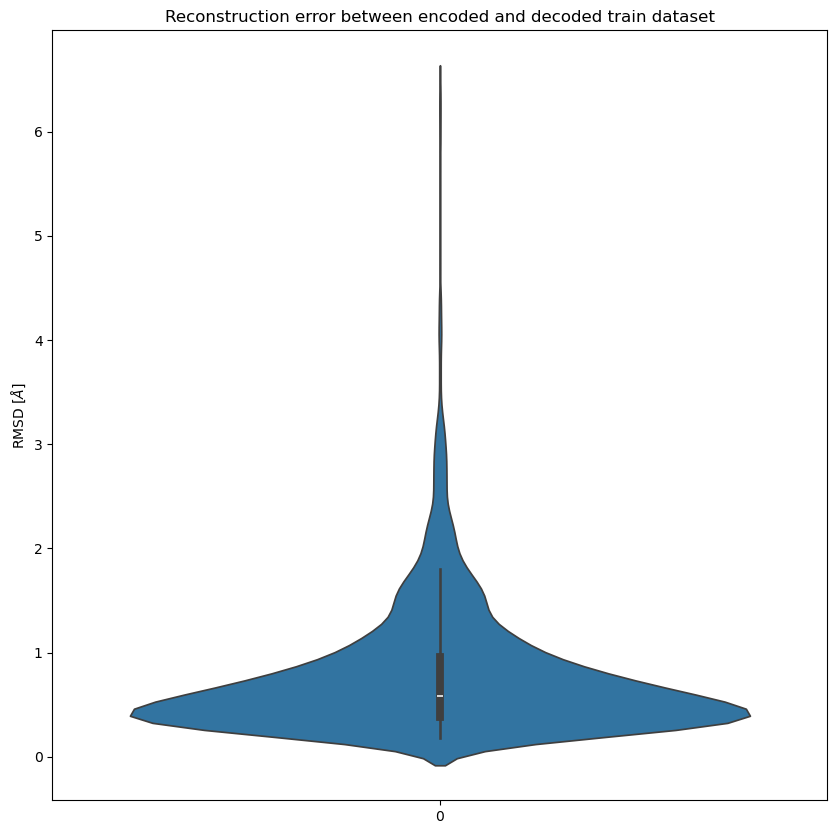

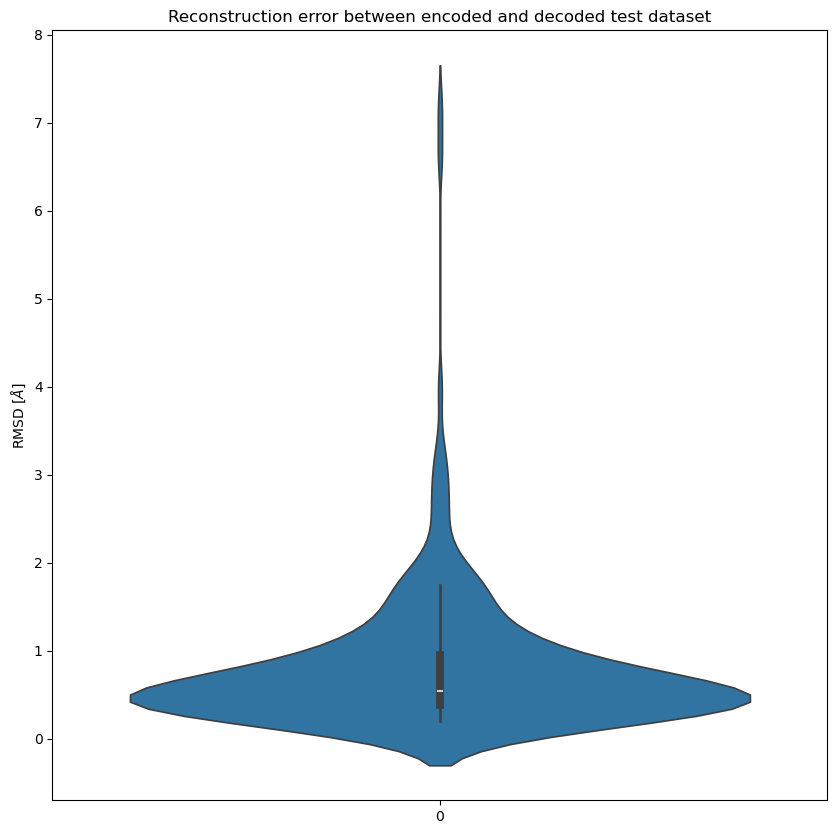

In [11]:

data = [err_train]
f = plt.figure(figsize=(10, 10))
sns.violinplot(data)
plt.ylabel('RMSD [$\AA$]')
plt.title('Reconstruction error between encoded and decoded train dataset')
plt.show()
f.savefig(f'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/err_train_{saveName}.png', dpi=300)

data = [err_test]
f = plt.figure(figsize=(10, 10))
sns.violinplot(data)
plt.ylabel('RMSD [$\AA$]')
plt.title('Reconstruction error between encoded and decoded test dataset')
plt.show()
f.savefig(f'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/err_test_{saveName}.png', dpi=300)

Copied outlier (train): Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_train\4RWL_A.pdb -> Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/rmsd_outliers_train\4RWL_A.pdb
Copied outlier (train): Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_train\7WCX_A.pdb -> Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/rmsd_outliers_train\7WCX_A.pdb
Copied outlier (train): Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_train\8UOJ_A.pdb -> Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/rmsd_outliers_train\8UOJ_A.pdb
Copied outlier (train): Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_train\4LOP_B.pdb -> Results/run_trial_BRAFActivationLoop_postalign_clea

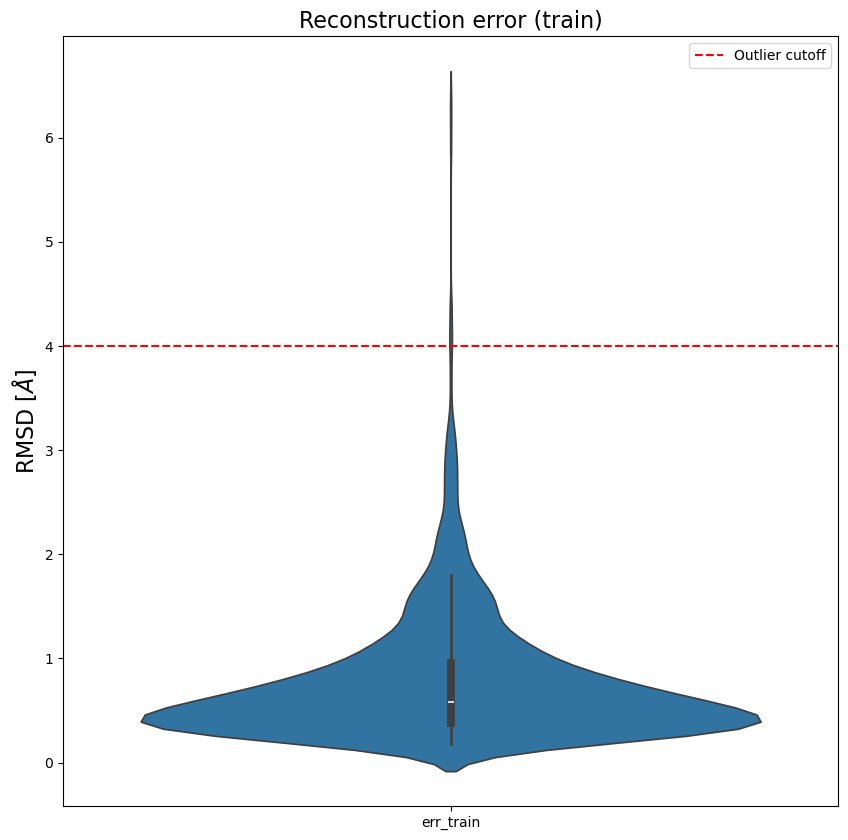

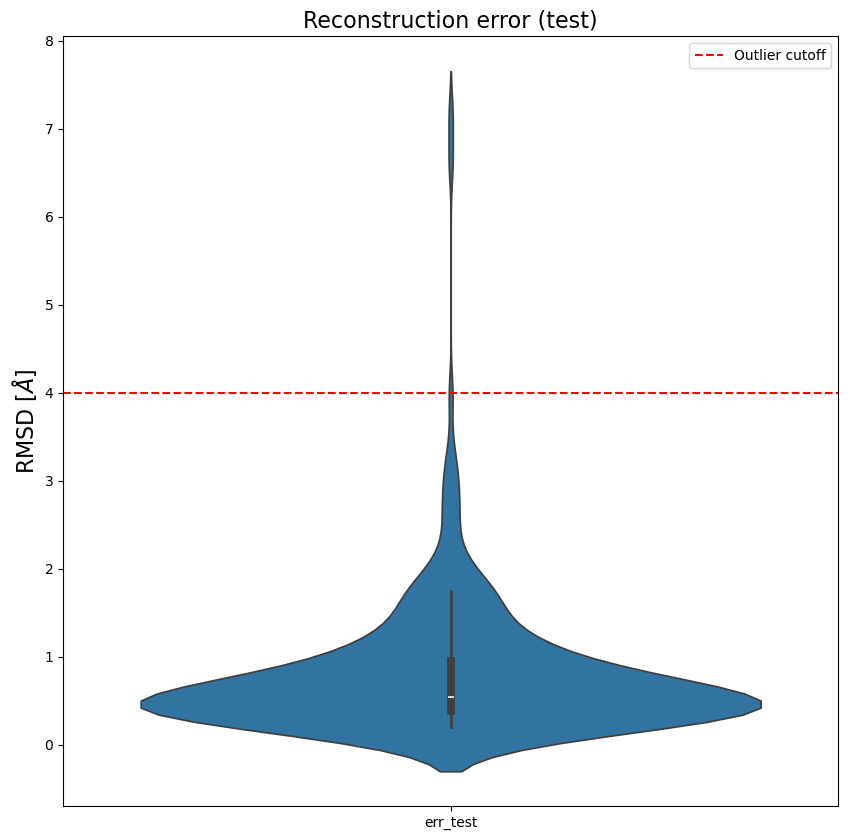

In [12]:
"""
This script filters out PDB structures with reconstruction errors above a 4 Å RMSD threshold, copies them into separate outlier folders for training and test sets, and visualizes the error distributions using violin plots.

"""
saveName = '_foldingnet_checkpoint'
train_err_csv = f'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/err_train_{saveName}.csv'
test_err_csv = f'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/err_test_{saveName}.csv'

# Load reconstruction errors from CSV
df_err_train = pd.read_csv(train_err_csv)   
df_err_test = pd.read_csv(test_err_csv)  

#Identify outlier indices with RMSD > 4
train_outlier_indices = df_err_train.index[df_err_train['err_train'] > 4].to_list()
test_outlier_indices = df_err_test.index[df_err_test['err_test'] > 4].to_list()

#Get sorted list of original PDB filenames
folder_name = 'Results/fitted_matlab_segments/mustang_endsAlignment_cleaned_noOutliers'
files = sorted([
    f for f in os.listdir(folder_name)
    if os.path.isfile(os.path.join(folder_name, f)) and f != 'combined.pdb'
])

#Create directories to store outlier PDB files
outlier_dir_train = 'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/rmsd_outliers_train'
outlier_dir_test = 'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/rmsd_outliers_test'
os.makedirs(outlier_dir_train, exist_ok=True)
os.makedirs(outlier_dir_test, exist_ok=True)

#Copy training outliers into designated folder
source_dir_train = 'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_train'
for row_i in train_outlier_indices:
    frame_idx = train_indices[row_i]          
    original_filename = files[frame_idx]     

    src = os.path.join(source_dir_train, original_filename)
    dst = os.path.join(outlier_dir_train, original_filename)

    if os.path.exists(src):
        shutil.copy(src, dst)
        print(f'Copied outlier (train): {src} -> {dst}')
    else:
        print(f'Skipping missing file (train): {src}')

#Copy test outliers into designated folder
source_dir_test = 'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_test'
for row_i in test_outlier_indices:
    frame_idx = test_indices[row_i]
    original_filename = files[frame_idx]

    src = os.path.join(source_dir_test, original_filename)
    dst = os.path.join(outlier_dir_test, original_filename)

    if os.path.exists(src):
        shutil.copy(src, dst)
        print(f'Copied outlier (test): {src} -> {dst}')
    else:
        print(f'Skipping missing file (test): {src}')

#Plot violin plot for training reconstruction errors
f = plt.figure(figsize=(10, 10))
sns.violinplot(data=[df_err_train['err_train']])
plt.axhline(y=4.0, color='red', linestyle='--', label='Outlier cutoff')
plt.legend()
plt.ylabel('RMSD [$\\AA$]', fontsize=16)
plt.title('Reconstruction error (train)', fontsize=16)
plt.show()
f.savefig(f'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/err_train_{saveName}.png', dpi=300)

#Plot violin plot for test reconstruction errors
f = plt.figure(figsize=(10, 10))
sns.violinplot(data=[df_err_test['err_test']])
plt.axhline(y=4.0, color='red', linestyle='--', label='Outlier cutoff')
plt.legend()
plt.ylabel('RMSD [$\\AA$]', fontsize=16)
plt.title('Reconstruction error (test)', fontsize=16)
plt.show()
f.savefig(f'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/err_test_{saveName}.png', dpi=300)


In [13]:
MA.setup_grid(30)
landscape_err_latent, landscape_err_3d, xaxis, yaxis = MA.scan_error()
df_landscape_err_latent = pd.DataFrame(landscape_err_latent)
df_landscape_err_latent.to_csv(f'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/landscape_err_latent_{saveName}.csv', index=False)

df_landscape_err_3d = pd.DataFrame(landscape_err_3d)
df_landscape_err_3d.to_csv(f'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/landscape_err_3d_{saveName}.csv', index=False)

df_xaxis = pd.DataFrame(xaxis)
df_xaxis.to_csv(f'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/landscape_err_xaxis_{saveName}.csv', index=False)

df_yaxis = pd.DataFrame(yaxis)
df_yaxis.to_csv(f'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/landscape_err_yaxis_{saveName}.csv', index=False)

Decoding grid_decoded: 100%|██████████| 113/113 [00:01<00:00, 63.77it/s]


Projection into latent space.

In [14]:
with torch.no_grad():
    z = net.encode(data_train.dataset)

z_training = z.data.cpu().numpy()[:, :, 0]
df_z_train = pd.DataFrame(z_training)

df_z_train['train_index'] = train_indices

mapping_df = pd.read_csv('train_index_mapping_11_newsplit.csv') 
mapping_dict = mapping_df.set_index('train_index')['pdb_filename'].to_dict()

df_z_train['pdb_filename'] = df_z_train['train_index'].map(mapping_dict)

df_z_train.to_csv(
    f'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/landscape_encoded_train_coordinates.csv',
    index=False
)


In [15]:
with torch.no_grad():
    z = net.encode(data_test.dataset)

z_test = z.data.cpu().numpy()[:, :, 0]
df_z_test = pd.DataFrame(z_test)

df_z_test['test_index'] = test_indices

test_mapping_df = pd.read_csv('test_index_mapping_11_newsplit.csv') 
test_mapping_dict = test_mapping_df.set_index('valid_index')['pdb_filename'].to_dict()

df_z_test['pdb_filename'] = df_z_test['test_index'].map(test_mapping_dict)

df_z_test.to_csv(
    f'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/landscape_encoded_test_coordinates.csv',
    index=False
)

Train: 2137 / 2137
Test: 291 / 291


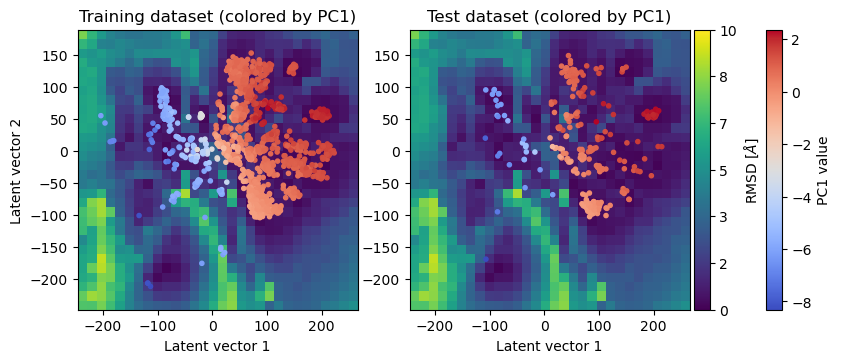

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import glob

# Load precomputed latent space RMSD landscape (X, Y grid and Z values)
x_file = glob.glob("Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/landscape_err_xaxis__foldingnet_checkpoint.csv")
y_file = glob.glob("Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/landscape_err_yaxis__foldingnet_checkpoint.csv")
z_file = glob.glob("Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/landscape_err_latent__foldingnet_checkpoint.csv")

df_x = [pd.read_csv(file, header=None).to_numpy() for file in x_file]
df_y = [pd.read_csv(file, header=None).to_numpy() for file in y_file]
df_z = [pd.read_csv(file).to_numpy() for file in z_file]

df_z=np.squeeze(np.fliplr(df_z))

# Load PC1 values for each structure
pca_df = pd.read_csv(
    'pc1_ends_noOutliers.txt',
    delim_whitespace=True,
    comment='#',
    header=None,
    names=['PC1_value', 'pdb_filename']
)

pca_df['pdb_filename'] = pca_df['pdb_filename'].str.replace('.pdb', '', regex=False)

# Load latent coordinates and clean filenames
latent_train = pd.read_csv(
    'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/landscape_encoded_train_coordinates.csv'
)
latent_test = pd.read_csv(
    'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/landscape_encoded_test_coordinates.csv'
)

latent_train['pdb_filename'] = latent_train['pdb_filename'].str.replace('.pdb', '', regex=False)
latent_test['pdb_filename'] = latent_test['pdb_filename'].str.replace('.pdb', '', regex=False)

# Merge PC1 values into latent coordinate dataframes
merged_train = pd.merge(latent_train, pca_df, on='pdb_filename', how='inner')
merged_test = pd.merge(latent_test, pca_df, on='pdb_filename', how='inner')

print(f"Train: {len(merged_train)} / {len(latent_train)}")
print(f"Test: {len(merged_test)} / {len(latent_test)}")

# Extract coordinates and PC1 values
x_encoded_train = merged_train.iloc[:, 0]
y_encoded_train = merged_train.iloc[:, 1]
pc1_train = merged_train['PC1_value']

x_encoded_test = merged_test.iloc[:, 0]
y_encoded_test = merged_test.iloc[:, 1]
pc1_test = merged_test['PC1_value']

fig = plt.figure(figsize=(8, 8))

# Plot for training data
ax1 = fig.add_axes([0.0, 0.1, 0.35, 0.35])
ax1.imshow(df_z, cmap='viridis', vmin=0., vmax=10.,
           extent=[np.min(df_x), np.max(df_x), np.min(df_y), np.max(df_y)])
ax1.scatter(x_encoded_train, y_encoded_train, c=pc1_train, marker='.', cmap='coolwarm')
ax1.set_xlabel('Latent vector 1')
ax1.set_ylabel('Latent vector 2')
ax1.set_title('Training dataset (colored by PC1)')
ax1.set_aspect('auto')  

# Plot for test data
ax2 = fig.add_axes([0.415, 0.1, 0.35, 0.35])
im = ax2.imshow(df_z, cmap='viridis', vmin=0., vmax=10.,
                extent=[np.min(df_x), np.max(df_x), np.min(df_y), np.max(df_y)])
ax2.scatter(x_encoded_test, y_encoded_test, c=pc1_test, marker='.', cmap='coolwarm')
ax2.set_xlabel('Latent vector 1')
ax2.set_title('Test dataset (colored by PC1)')
ax2.set_aspect('auto')  


# RMSD colorbar
cbar_ax2 = fig.add_axes([0.77, 0.1, 0.02, 0.35])
cbar_ax2.tick_params(left=False, labelleft=False, right=True, labelright=True, labelbottom=False, bottom=False)
cbar = fig.colorbar(im, cax=cbar_ax2, label='RMSD [$\AA$]')
cbar_ticks = np.linspace(0, 10, 7)
cbar.set_ticks(cbar_ticks)
cbar.set_ticklabels([f'{tick:.0f}' for tick in cbar_ticks])

# PC1 colorbar
cbar_ax_pca = fig.add_axes([0.86, 0.1, 0.02, 0.35])
pca_norm = plt.Normalize(vmin=min(pc1_train.min(), pc1_test.min()),
                         vmax=max(pc1_train.max(), pc1_test.max()))
cbar_pca = fig.colorbar(
    plt.cm.ScalarMappable(norm=pca_norm, cmap='coolwarm'),
    cax=cbar_ax_pca,
    label='PC1 value'
)

plt.savefig(
    'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/RMSDlandscapesOnePlot_coloredByPC1.png',
    dpi=300, bbox_inches='tight'
)
plt.show()

Train匹配数量: 2137 / 2137
Test匹配数量: 291 / 291


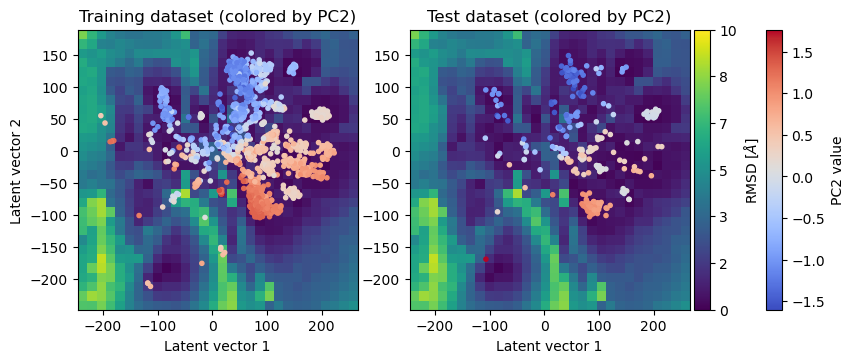

In [17]:
"""
Same as before but using PC2 to color the points 
"""
import pandas as pd
import matplotlib.pyplot as plt
import glob

x_file = glob.glob("Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/landscape_err_xaxis__foldingnet_checkpoint.csv")
y_file = glob.glob("Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/landscape_err_yaxis__foldingnet_checkpoint.csv")
z_file = glob.glob("Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/landscape_err_latent__foldingnet_checkpoint.csv")

df_x = [pd.read_csv(file, header=None).to_numpy() for file in x_file]
df_y = [pd.read_csv(file, header=None).to_numpy() for file in y_file]
df_z = [pd.read_csv(file).to_numpy() for file in z_file]

df_z=np.squeeze(np.fliplr(df_z))

pca_df = pd.read_csv(
    'pc2_ends_noOutliers.txt',
    delim_whitespace=True,
    comment='#',
    header=None,
    names=['PC1_value', 'pdb_filename']
)

pca_df['pdb_filename'] = pca_df['pdb_filename'].str.replace('.pdb', '', regex=False)

latent_train = pd.read_csv(
    'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/landscape_encoded_train_coordinates.csv'
)
latent_test = pd.read_csv(
    'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/landscape_encoded_test_coordinates.csv'
)

latent_train['pdb_filename'] = latent_train['pdb_filename'].str.replace('.pdb', '', regex=False)
latent_test['pdb_filename'] = latent_test['pdb_filename'].str.replace('.pdb', '', regex=False)

merged_train = pd.merge(latent_train, pca_df, on='pdb_filename', how='inner')
merged_test = pd.merge(latent_test, pca_df, on='pdb_filename', how='inner')

print(f"Train匹配数量: {len(merged_train)} / {len(latent_train)}")
print(f"Test匹配数量: {len(merged_test)} / {len(latent_test)}")

x_encoded_train = merged_train.iloc[:, 0]
y_encoded_train = merged_train.iloc[:, 1]
pc1_train = merged_train['PC1_value']

x_encoded_test = merged_test.iloc[:, 0]
y_encoded_test = merged_test.iloc[:, 1]
pc1_test = merged_test['PC1_value']

fig = plt.figure(figsize=(8, 8))

ax1 = fig.add_axes([0.0, 0.1, 0.35, 0.35])
ax1.imshow(df_z, cmap='viridis', vmin=0., vmax=10.,
           extent=[np.min(df_x), np.max(df_x), np.min(df_y), np.max(df_y)])
ax1.scatter(x_encoded_train, y_encoded_train, c=pc1_train, marker='.', cmap='coolwarm')
ax1.set_xlabel('Latent vector 1')
ax1.set_ylabel('Latent vector 2')
ax1.set_title('Training dataset (colored by PC2)')
ax1.set_aspect('auto')  

ax2 = fig.add_axes([0.415, 0.1, 0.35, 0.35])
im = ax2.imshow(df_z, cmap='viridis', vmin=0., vmax=10.,
                extent=[np.min(df_x), np.max(df_x), np.min(df_y), np.max(df_y)])
ax2.scatter(x_encoded_test, y_encoded_test, c=pc1_test, marker='.', cmap='coolwarm')
ax2.set_xlabel('Latent vector 1')
ax2.set_title('Test dataset (colored by PC2)')
ax2.set_aspect('auto')  

cbar_ax2 = fig.add_axes([0.77, 0.1, 0.02, 0.35])
cbar_ax2.tick_params(left=False, labelleft=False, right=True, labelright=True, labelbottom=False, bottom=False)
cbar = fig.colorbar(im, cax=cbar_ax2, label='RMSD [$\AA$]')
cbar_ticks = np.linspace(0, 10, 7)
cbar.set_ticks(cbar_ticks)
cbar.set_ticklabels([f'{tick:.0f}' for tick in cbar_ticks])

cbar_ax_pca = fig.add_axes([0.86, 0.1, 0.02, 0.35])
pca_norm = plt.Normalize(vmin=min(pc1_train.min(), pc1_test.min()),
                         vmax=max(pc1_train.max(), pc1_test.max()))
cbar_pca = fig.colorbar(
    plt.cm.ScalarMappable(norm=pca_norm, cmap='coolwarm'),
    cax=cbar_ax_pca,
    label='PC2 value'
)

plt.savefig(
    'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/RMSDlandscapesOnePlot_coloredByPC2.png',
    dpi=300, bbox_inches='tight'
)
plt.show()